In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
from tqdm import trange

In [2]:
from numba import njit, prange
@njit(fastmath=True)
def q(
    k: int, 
    t: float
):
    '''
    Input: 
    k - номер источника, принимает значения 0 или 1; 
    t - время с начала эксперимента
    Output: 
    мощность источника k в момент времени t
    '''
    if k == 0:
        teta = 43
    else:
        teta = 73
    return 100 * (np.sin(2 * np.pi / teta * t) + 1)

@njit(parallel = True)
def diffuse_step(
    it: int,
    T: np.ndarray,
    dx: float,
    dt: float,
    Dij: np.ndarray
):   
    '''
    Функция изменения поля температур на итеррации it
    Input:
    it - номер итерации
    T - Трехмерный массив Numpy 2*N*N, представляет собой два поля температур, текущее и предыдущее
    dt - шаг по времени
    Dij - двумерный массив Numpy N*N - карта коэффициентов диффузии
    '''
    prev = it % 2
    cur  = (it + 1) % 2    
    for i in prange(1, N - 1):
        for j in range(1, N - 1):
            g = dt * Dij[i, j] / dx**2
            T[cur, i, j] = T[prev, i, j] + \
            g * (T[prev, i+1, j] + 
                T[prev, i-1, j] + 
                T[prev, i, j+1] + 
                T[prev, i, j-1] -
                4 * T[prev, i, j])              

In [3]:
def bound_cond(T: np.ndarray):
    '''
    Функция задает граничные условия на ребрах пластины.
    Input:
    T - Трехмерный массив Numpy 2*N*N, представляет собой два поля температур, текущее и предыдущее
    '''
    T[:, 0, :] = 0
    T[:, -1, :] = T[:, -2, :]
    T[:, :, 0] = 0
    T[:, :, -1] = T[:, :, -2]

In [4]:
def heat(
    T:np.ndarray, 
    it: int,
    dt: float,
    heat_param: np.ndarray
):
    '''
    Функция нагревания источников. 
    Input:
    it - номер итерации
    T - Трехмерный массив Numpy 2*N*N, представляет собой два поля температур, текущее и предыдущее
    dt - шаг по времени
    heat_param - массив numpy k*4, где k - количество источников; 
    в каждом из двух подмассивов данные об источнике [ширина, высота, координата центра по x, координата центра по y]
    '''
    for i in range(len(heat_param)):
        T[:, int(heat_param[i][3] - heat_param[i][1] // 2) : int(heat_param[i][3] + heat_param[i][1] // 2), int(heat_param[i][2] - heat_param[i][0] // 2) : int(heat_param[i][2] + heat_param[i][0] // 2)] += q(i, it * dt) * dt

In [5]:
def find_period(
    temperature: np.ndarray,
    dt: float
):
    '''
    Функция восстановления периодов колебаний температуры в точке
    Input:
    temperature - массив Numpy температур в точке за все время эксперимента
    dt - шаг по времени
    Output:
    массив периодов колебаний
    '''
    fft_values = np.fft.rfft(temperature)
    frequencies = np.fft.rfftfreq(len(temperature), dt)
    peaks, _ = sp.signal.find_peaks(np.abs(fft_values), distance=10)
    periods = 1 / frequencies[peaks]
    return np.round(periods, 3)

In [6]:
D0 = 1
D1 = 1e-2
C = 0.2
t_m = 600

100%|██████████| 768000/768000 [17:15<00:00, 741.67it/s]


Время вычисления для размеров 960 на 960: 1035.5340542793274 s


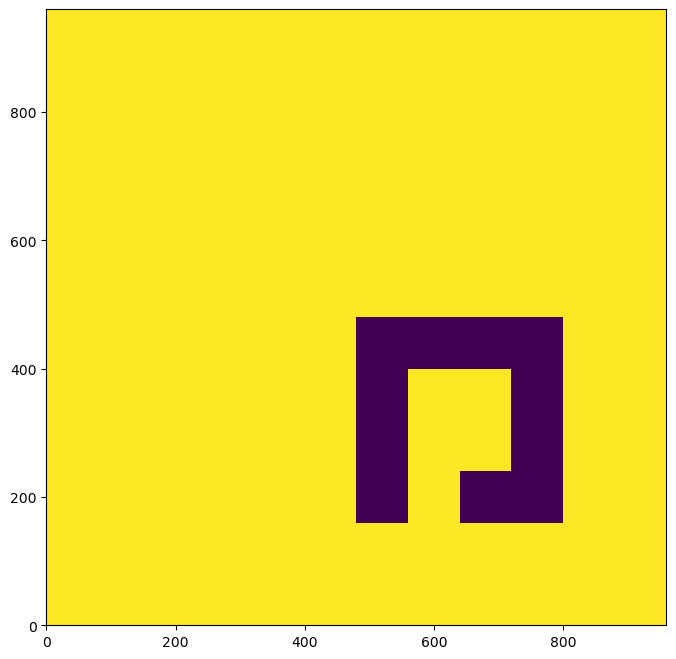

In [7]:
N = 960
dx = 60/N
cell_size = N//60
dt = C * dx**2 / D0
it_m = int(t_m/dt)

Dij = np.full((N, N), D0)
Dij[10*cell_size:30*cell_size, 30*cell_size:50*cell_size]=D1
Dij[15*cell_size:25*cell_size, 35*cell_size:45*cell_size]=D0
Dij[10*cell_size:15*cell_size, 35*cell_size:40*cell_size]=D0
plt.figure(figsize=(8, 8))
plt.pcolormesh(Dij)

heat_param = np.array([[5, 20, 7.5, 30], [20, 5, 30, 7.5]])*cell_size
tests = {0: (20*cell_size, 20*cell_size),
         1: (20*cell_size, 40*cell_size),
         2: (40*cell_size, 40*cell_size),
         3: (40*cell_size, 20*cell_size)}
tests_names = {0: str(20*cell_size) + ',' + str(20*cell_size),
         1: str(20*cell_size) + ',' + str(40*cell_size),
         2: str(40*cell_size) + ',' + str(40*cell_size),
         3: str(40*cell_size) + ',' + str(20*cell_size)}
tests_values = np.empty((4, it_m))

T = np.zeros((2, N, N))
start = time.time()
for it in trange(it_m):
    heat(T, it, dt, heat_param)
    bound_cond(T)
    diffuse_step(it, T, dx, dt, Dij)
    for i, (x, y) in tests.items():
        tests_values[i, it] = T[0, y, x]
end = time.time()
print(f"Время вычисления для размеров {N} на {N}:", (end-start), "s")

f = open('time.txt','a')
f.write(str(end-start)+' ')
f.close()


np.save('T_map_N='+str(N)+'.npy', T[0], allow_pickle=False)
np.save('Tests_N='+str(N)+'.npy', np.array([list(x) for x in tests.values()]), allow_pickle=False)
np.save('Tests_values_N='+str(N)+'.npy', tests_values, allow_pickle=False)

In [11]:
def show_info_and_visualization(N: int):
    '''
    Функция рисут тепловую карту, графики температур в точках проб,
    а также выводит время вычисления результатов эксперимента и периоды колебаний температуры для каждой пробы
    Input: N - размер массива поля температур
    '''
    tests_values = np.load('Tests_values_N='+str(N) +'.npy')
    T = np.load('T_map_N='+str(N) +'.npy')
    tests = np.load('Tests_N='+str(N) +'.npy')
    tests_names = {0: str(tests[0, 0]) + ',' + str(tests[0, 1]),
                 1: str(tests[1, 0]) + ',' + str(tests[1, 1]),
                 2: str(tests[2, 0]) + ',' + str(tests[2, 1]),
                 3: str(tests[3, 0]) + ',' + str(tests[3, 1])}
    dx = 60/N
    D0 = 1
    dt = C * dx**2 / D0
    it_m = int(t_m/dt)
    
    f = open("time.txt", "r")
    print(f"Время вычисления для размеров {N} на {N}:", f.read().split(' ')[int(math.log2(N//60))], "s")
    f.close()
    
    for i in range(4):
        print(f'Периоды пробы {i}, с координатами ({tests_names[i]}): {find_period(tests_values[i], dt)}')
    
    colors = ['red', 'blue', 'green', 'orange']
    plt.figure(figsize=(8, 6))
    colorbar = plt.pcolormesh(T)
    for i, color in zip(range(4), colors):
        x, y = list(tests[i])[0], list(tests[i])[1]
        plt.scatter(x, y, label=f'Проба {i}, координаты ('+tests_names[i]+')', color=color, s=30)
    plt.colorbar(colorbar)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    for i, color in zip(range(4), colors):
        plt.plot(np.arange(it_m)*dt, tests_values[i], label=f'Проба {i}, координаты (' +tests_names[i]+')', color=color)
    plt.xlabel('Время')
    plt.ylabel('Температура')
    plt.legend()
    plt.show()


Время вычисления для размеров 60 на 60: 0.5867853164672852 s
Периоды пробы 0, с координатами (20,20): [75.     0.402]
Периоды пробы 1, с координатами (20,40): [42.857  0.404]
Периоды пробы 2, с координатами (40,40): [0.401]
Периоды пробы 3, с координатами (40,20): [75.     0.407  0.402]


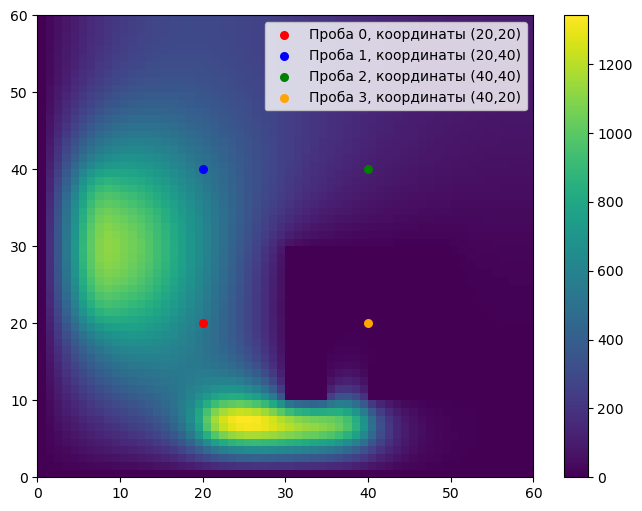

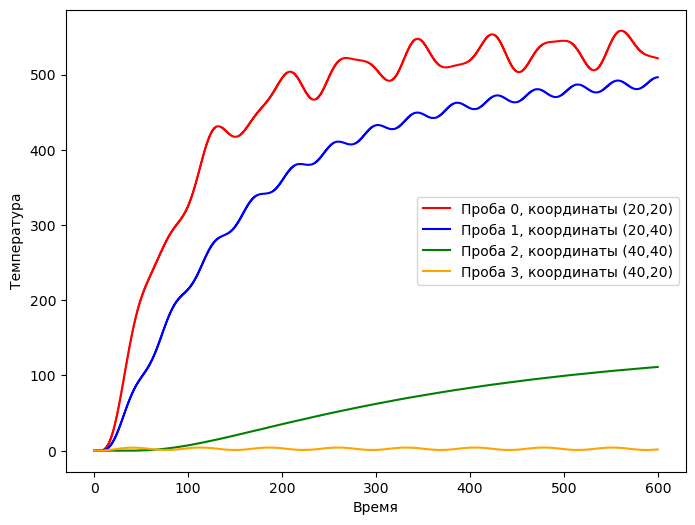

In [17]:
show_info_and_visualization(60)

Время вычисления для размеров 120 на 120: 1.4674994945526123 s
Периоды пробы 0, с координатами (40,40): [75.   0.1  0.1]
Периоды пробы 1, с координатами (40,80): [42.857  0.1  ]
Периоды пробы 2, с координатами (80,80): [0.1 0.1]
Периоды пробы 3, с координатами (80,40): [75.     0.101  0.1  ]


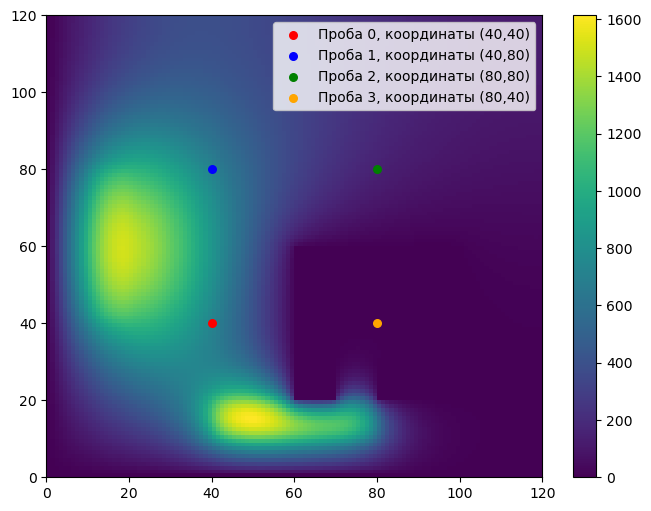

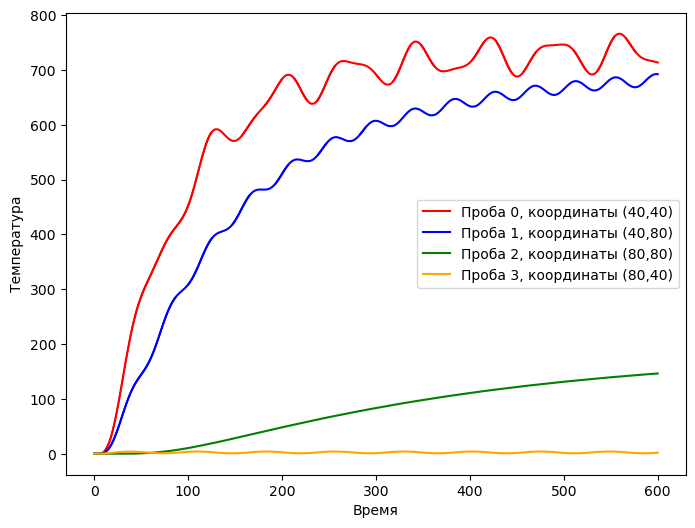

In [18]:
show_info_and_visualization(120)

Время вычисления для размеров 240 на 240: 4.481760501861572 s
Периоды пробы 0, с координатами (80,80): [7.5e+01 2.5e-02 2.5e-02]
Периоды пробы 1, с координатами (80,160): [4.2857e+01 2.5000e-02]
Периоды пробы 2, с координатами (160,160): [0.025 0.025]
Периоды пробы 3, с координатами (160,80): [7.5e+01 2.5e-02 2.5e-02 2.5e-02]


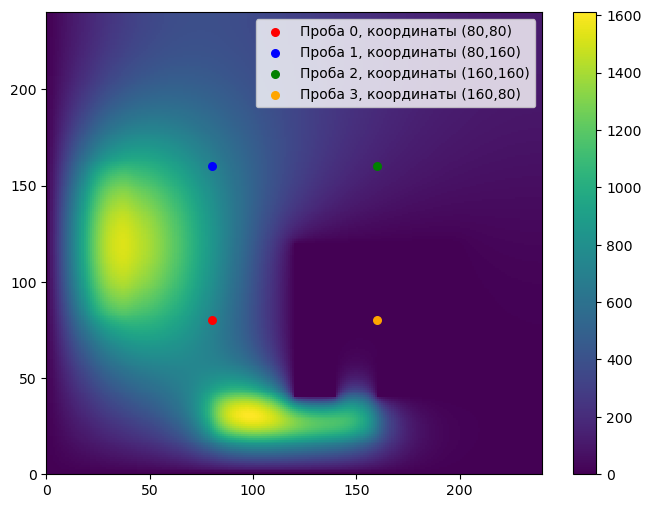

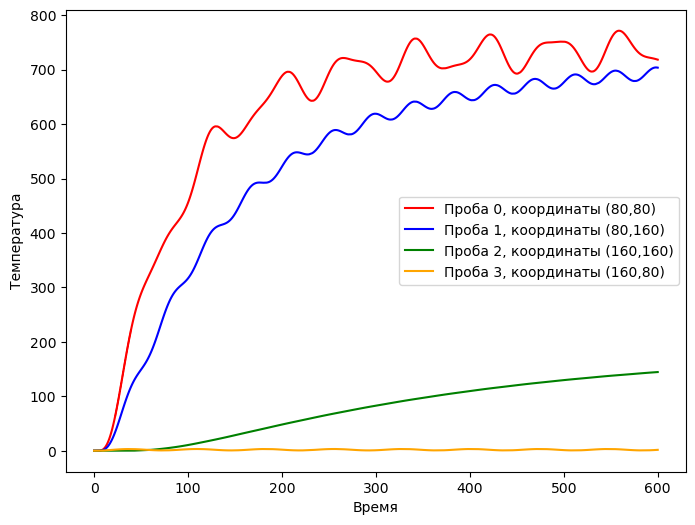

In [19]:
show_info_and_visualization(240)

Время вычисления для размеров 480 на 480: 32.862494468688965 s
Периоды пробы 0, с координатами (160,160): [7.5e+01 6.0e-03 6.0e-03]
Периоды пробы 1, с координатами (160,320): [4.2857e+01 6.0000e-03]
Периоды пробы 2, с координатами (320,320): [0.006 0.006]
Периоды пробы 3, с координатами (320,160): [7.5e+01 6.0e-03 6.0e-03 6.0e-03]


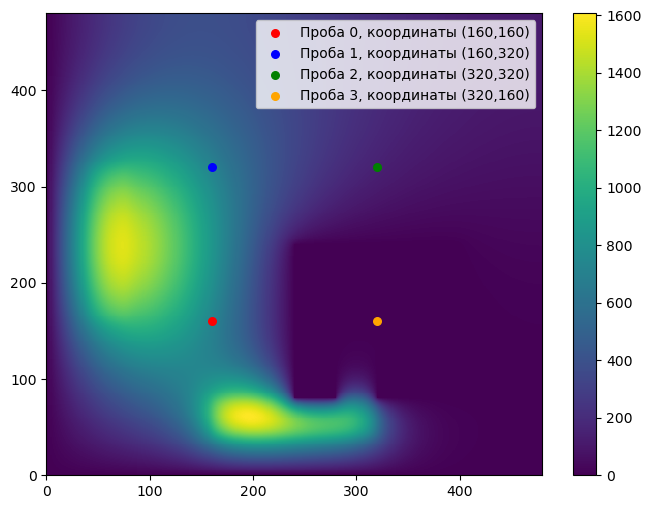

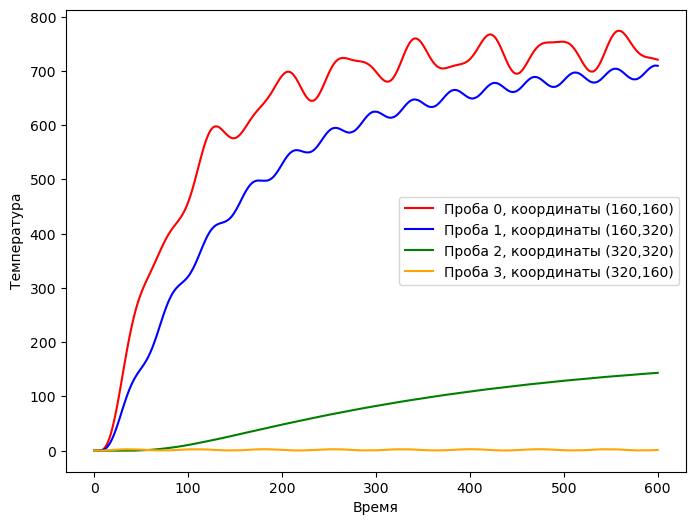

In [20]:
show_info_and_visualization(480)

Время вычисления для размеров 960 на 960: 1035.5340542793274 s
Периоды пробы 0, с координатами (320,320): [7.5e+01 2.0e-03 2.0e-03]
Периоды пробы 1, с координатами (320,640): [4.2857e+01 2.0000e-03]
Периоды пробы 2, с координатами (640,640): [0.002 0.002]
Периоды пробы 3, с координатами (640,320): [7.5e+01 2.0e-03 2.0e-03 2.0e-03]


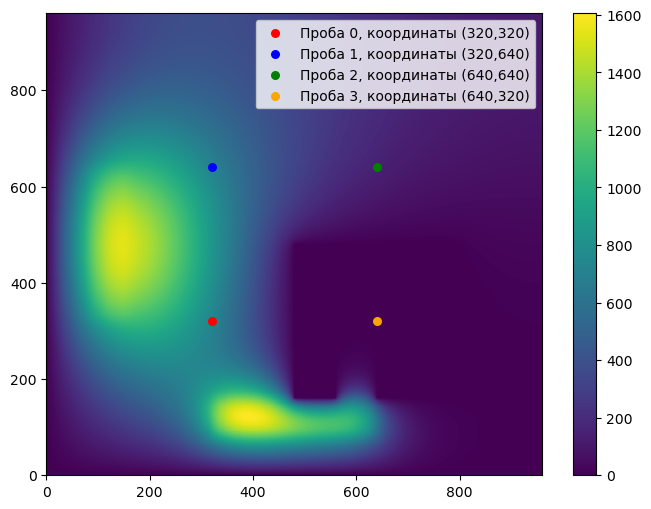

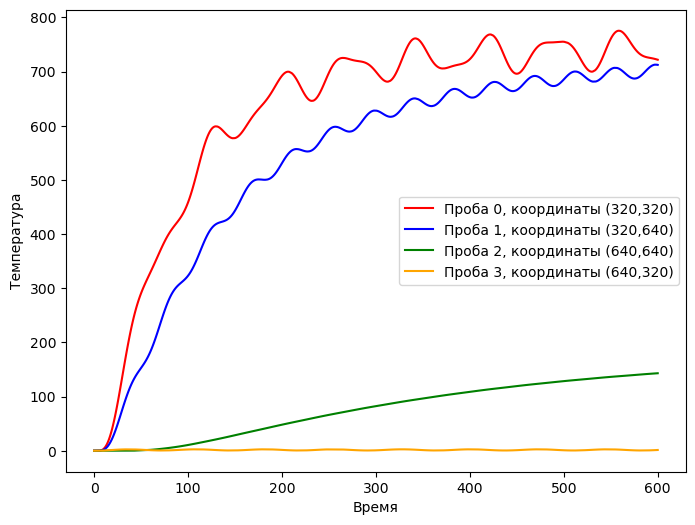

In [21]:
show_info_and_visualization(960)